<a href="https://www.kaggle.com/code/mubashirjawad01/cucumber-disease-recognition?scriptVersionId=271045756" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Import Libraries**

In [1]:
import os
import random
import math
from glob import glob
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models





2025-10-26 15:14:58.881713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761491699.115741      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761491699.179630      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. **Analyze and Report on class balance to identify potential biases.**

count
Pythium Fruit Rot    169
Anthracnose          160
Bacterial Wilt       160
Belly Rot            160
Downy Mildew         160
Fresh Cucumber       160
Fresh Leaf           160
Gummy Stem Blight    160

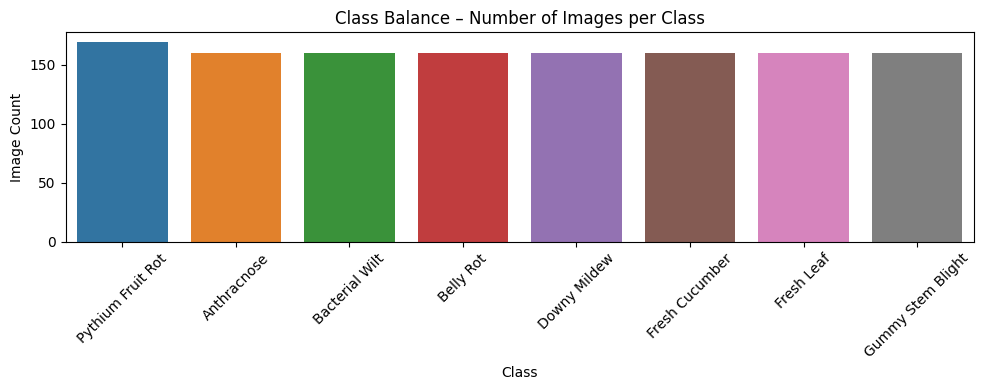

In [2]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DATA_ROOT = "/kaggle/input/cucumber-disease-recognition-dataset/Original Image"
TRAIN_DIR = os.path.join(DATA_ROOT, "train") if os.path.exists(os.path.join(DATA_ROOT, "train")) else DATA_ROOT

#finding class subfolders
classes = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]  
classes.sort()

class_counts = {}
for cls in classes:
    path = os.path.join(TRAIN_DIR, cls)
    files = [f for f in os.listdir(path) if os.path.splitext(f)[1].lower() in ('.jpg', '.jpeg', '.png')]
    class_counts[cls] = len(files)

# Arranging data in column or tables
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
display(df_counts)

# visualize class balance
plt.figure(figsize=(10, 4))
df_counts_reset = df_counts.reset_index().rename(columns={'index': 'class'})
sns.barplot(x='class', y='count', data=df_counts_reset)
plt.xticks(rotation=45)
plt.title("Class Balance – Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


# **2.Visualize sample images to understand intra-class variation and data quality.**

In [3]:
import random
from PIL import Image
import matplotlib.pyplot as plt

ncols = 4
nrows = len(classes)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 3*nrows))

for i, cls in enumerate(classes):
    cls_path = os.path.join(TRAIN_DIR, cls)
    files = [f for f in os.listdir(cls_path) if os.path.splitext(f)[1].lower() in ('.jpg', '.jpeg', '.png')]
    sample = random.sample(files, min(ncols, len(files)))
    for j in range(ncols):
        ax = axes[i, j] if nrows > 1 else axes[j]
        ax.axis('off')
        if j < len(sample):
            img = Image.open(os.path.join(cls_path, sample[j])).convert('RGB')
            ax.imshow(img)
        if j == 0:
            ax.set_title(f"{cls}\n({class_counts[cls]} images)", fontsize=10)

plt.tight_layout()
plt.show()


# **3**. **Investigate image properties such as resolution, aspect ratio, and color distributions to inform preprocessing strategies.**


Total images scanned: 1289
Image color modes: {'RGB': 1289}


width  height       area  aspect_ratio
count  1289.0  1289.0     1289.0  1.289000e+03
mean   2296.0  1724.0  3958304.0  1.331787e+00
std       0.0     0.0        0.0  2.176882e-14
min    2296.0  1724.0  3958304.0  1.331787e+00
25%    2296.0  1724.0  3958304.0  1.331787e+00
50%    2296.0  1724.0  3958304.0  1.331787e+00
75%    2296.0  1724.0  3958304.0  1.331787e+00
max    2296.0  1724.0  3958304.0  1.331787e+00

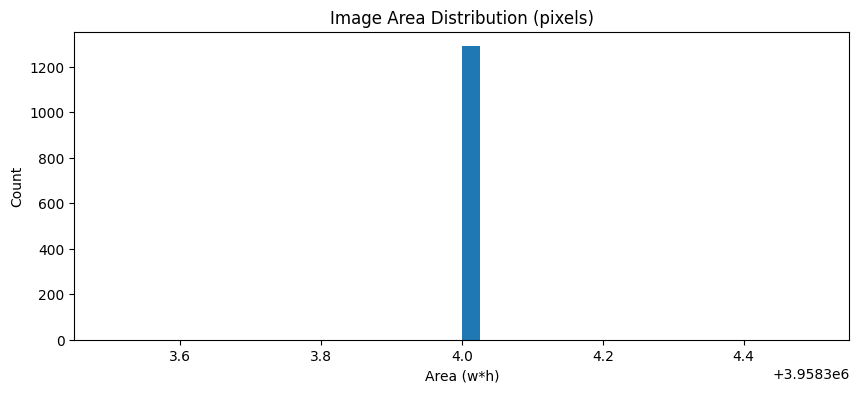

Processed 1/50 images
Processed 11/50 images
Processed 21/50 images
Processed 31/50 images
Processed 41/50 images


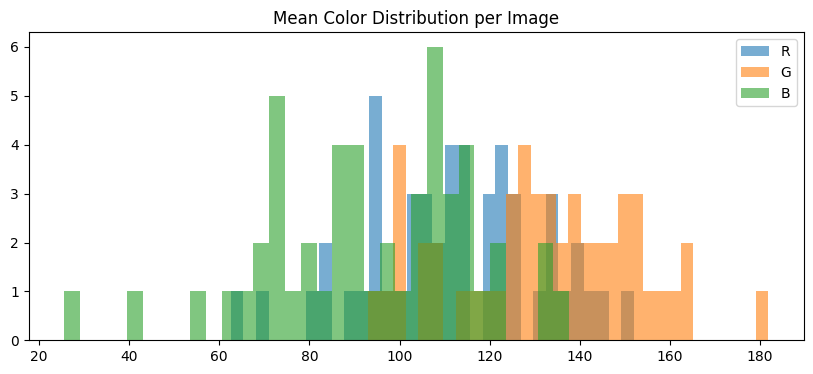

In [4]:
import cv2
import numpy as np
from collections import Counter
from PIL import Image

def im_info(path):
    try:
        with Image.open(path) as im:
            w, h = im.size
            mode = im.mode
        return w, h, mode
    except:
        return None

# get all image paths
image_paths = []
for cls in classes:
    folder = os.path.join(TRAIN_DIR, cls)
    for f in os.listdir(folder):
        if os.path.splitext(f)[1].lower() in ('.jpg', '.jpeg', '.png'):
            image_paths.append(os.path.join(folder, f))

print(f"Total images scanned: {len(image_paths)}")

res_list, aspect_list = [], []
modes = Counter()

for p in image_paths:
    info = im_info(p)
    if info is None:
        continue
    w, h, mode = info
    res_list.append((w, h))
    aspect_list.append(w / h if h > 0 else 0)
    modes[mode] += 1

import pandas as pd
res_df = pd.DataFrame(res_list, columns=['width', 'height'])
res_df['area'] = res_df['width'] * res_df['height']
res_df['aspect_ratio'] = res_df['width'] / res_df['height']

print("Image color modes:", dict(modes))
display(res_df.describe())

# plot resolution and aspect ratio
plt.figure(figsize=(10,4))
plt.hist(res_df['area'], bins=40)
plt.title('Image Area Distribution (pixels)')
plt.xlabel('Area (w*h)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,4))
plt.hist(res_df['aspect_ratio'].clip(0.2, 5), bins=40)
plt.title('Aspect Ratio (w/h) Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Count')
plt.show()

# Color channel distribution (sample) computing only per image means
sample_paths = random.sample(image_paths, min(50, len(image_paths)))
r_means, g_means, b_means = [], [], []

for i, p in enumerate(sample_paths):
    im = cv2.imread(p)
    if im is None:
        continue
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    mean_vals = im.mean(axis=(0,1))  # mean for R,G,B
    r_means.append(mean_vals[0])
    g_means.append(mean_vals[1])
    b_means.append(mean_vals[2])
    if i % 10 == 0:
        print(f"Processed {i+1}/{len(sample_paths)} images")

plt.figure(figsize=(10,4))
plt.hist(r_means, bins=32, alpha=0.6, label='R')
plt.hist(g_means, bins=32, alpha=0.6, label='G')
plt.hist(b_means, bins=32, alpha=0.6, label='B')
plt.legend()
plt.title('Mean Color Distribution per Image')
plt.show()



# **4. Conduct a small augmentation probe (e.g., crop, flip, color jitter) to determine which transformations are safe versus harmful for the dataset.**


In [5]:
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

PROBE_IMG_SIZE = (128, 128)
BATCH = 32
EPOCHS = 3

# baseline generator with validation split
base_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen_base = base_gen.flow_from_directory(TRAIN_DIR, target_size=PROBE_IMG_SIZE,
                                              batch_size=BATCH, class_mode='categorical',
                                              subset='training', shuffle=True, seed=123)
val_gen_base = base_gen.flow_from_directory(TRAIN_DIR, target_size=PROBE_IMG_SIZE,
                                            batch_size=BATCH, class_mode='categorical',
                                            subset='validation', shuffle=False, seed=123)

num_classes = train_gen_base.num_classes
print("Number of classes:", num_classes)

def make_small_model(input_shape=(128,128,3), num_classes=2):
    m = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPool2D(2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPool2D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

probe_configs = {
    "no_aug": ImageDataGenerator(rescale=1./255, validation_split=0.2),
    "flip": ImageDataGenerator(rescale=1./255, horizontal_flip=True, validation_split=0.2),
    "rotation_shift": ImageDataGenerator(rescale=1./255, rotation_range=20,
                                         width_shift_range=0.1, height_shift_range=0.1, validation_split=0.2),
    "color_jitter": ImageDataGenerator(rescale=1./255, brightness_range=(0.6,1.4), validation_split=0.2),
    "heavy_crop": ImageDataGenerator(rescale=1./255, zoom_range=(0.7,1.0), validation_split=0.2)
}

probe_results = {}

for name, gen in probe_configs.items():
    print(f"\n--- Running Probe: {name}")
    train_gen = gen.flow_from_directory(TRAIN_DIR, target_size=PROBE_IMG_SIZE,
                                        batch_size=BATCH, class_mode='categorical',
                                        subset='training', shuffle=True, seed=42)
    val_gen = gen.flow_from_directory(TRAIN_DIR, target_size=PROBE_IMG_SIZE,
                                      batch_size=BATCH, class_mode='categorical',
                                      subset='validation', shuffle=False, seed=42)
    model = make_small_model(input_shape=PROBE_IMG_SIZE+(3,), num_classes=num_classes)
    steps = min(50, math.ceil(train_gen.samples / BATCH))
    val_steps = min(20, math.ceil(val_gen.samples / BATCH))
    history = model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=steps,
                        validation_data=val_gen, validation_steps=val_steps, verbose=1)
    probe_results[name] = {
        'train_acc': history.history['accuracy'][-1],
        'val_acc': history.history['val_accuracy'][-1]
    }

# summarize probe results
probe_df = pd.DataFrame(probe_results).T
display(probe_df)

best = probe_df['val_acc'].idxmax()
print(f"\nBest probe config: {best} (val_acc = {probe_df.loc[best, 'val_acc']:.4f})")
probe_df.to_csv("augmentation_probe_results.csv")
print("Saved augmentation_probe_results.csv")

Found 1032 images belonging to 8 classes.
Found 257 images belonging to 8 classes.
Number of classes: 8

--- Running Probe: no_aug
Found 1032 images belonging to 8 classes.
Found 257 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-26 15:15:50.920001: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.1914 - loss: 2.1573 - val_accuracy: 0.3580 - val_loss: 1.5116
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.4705 - loss: 1.4174 - val_accuracy: 0.6031 - val_loss: 1.1148
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6354 - loss: 1.0029 - val_accuracy: 0.5642 - val_loss: 1.0497

--- Running Probe: flip
Found 1032 images belonging to 8 classes.
Found 257 images belonging to 8 classes.
Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.1741 - loss: 2.5261 - val_accuracy: 0.3930 - val_loss: 1.7290
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3644 - loss: 1.7082 - val_accuracy: 0.5486 - val_loss: 1.2569
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5718 - loss: 1.2166 - val_accuracy: 0.6265 - val_loss: 1.1257

--- Running Probe: rotation_shift
Found 1032 images belonging to 8 classes.
Found 257 images belonging to 8 classes.
Epoch 1/3
33/33 ━━━━━━━━

train_acc   val_acc
no_aug           0.655039  0.564202
flip             0.560078  0.626459
rotation_shift   0.462209  0.560311
color_jitter     0.519380  0.544747
heavy_crop       0.643411  0.575875


Best probe config: flip (val_acc = 0.6265)
Saved augmentation_probe_results.csv
